In [2]:
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import os
import keras
from random import randint

from keras.utils import normalize
from keras.metrics import MeanIoU

import tensorflow as tf


Segmentation Models: using `tf.keras` framework.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


Num GPUs Available:  0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _MklMatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
SIZE_X = 128
SIZE_Y = 128
n_classes = 4

images_path = "128_patches/images_as_128x128_patches.tif"
masked_path = "128_patches/masks_as_128x128_patches.tif"
train_images = []
train_masked = []

In [ ]:
with Image.open(images_path) as img:

    for i in range(img.n_frames):
        img.seek(i)

        img_np = np.array(img)
        print(img_np.shape)
        rgb_image = np.stack((img_np,)*3, axis=-1)
        print(rgb_image.shape)
        break 
        train_images.append(rgb_image)


with Image.open(masked_path) as img:


    for i in range(img.n_frames):
        img.seek(i)
        
        img_np = np.array(img)
        train_masked.append(img_np)

In [6]:
train_images = np.array(train_images)
train_masked = np.array(train_masked)

In [7]:
np.unique(train_masked)

array([1, 2, 3, 4], dtype=uint8)

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
n, h, w = train_masked.shape
train_masked_reshaped = train_masked.reshape(-1, 1)
train_masked_reshaped_encoded = label_encoder.fit_transform(train_masked_reshaped)
train_masked_encoded_original_shape = train_masked_reshaped_encoded.reshape(n, h, w)

train_masked_input = np.expand_dims(train_masked_encoded_original_shape, axis=3)

d:\OneDrive-CMU\Desktop_Dell\AILCAP\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
from sklearn.model_selection import train_test_split
# split entire dataset to train and testing 
x_train, x_test, y_train, y_test = train_test_split(train_images, train_masked_input, test_size=0.1, random_state=0)

# split training dataset to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=0)

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
print(y_train.shape, train_masks_cat.shape)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
print(y_train_cat.shape)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

test_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

(720, 128, 128, 1) (720, 128, 128, 4)
(720, 128, 128, 4)


In [10]:
activation='softmax'
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [11]:
print(x_train.shape)
print(y_train.shape)
print(y_train_cat.shape)

print(y_train_cat[0,:,:,0])

(720, 128, 128, 3)
(720, 128, 128, 1)
(720, 128, 128, 4)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [12]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input
prep_x_train = preprocess_input1(x_train)
prep_x_val = preprocess_input1(x_val)

# define model
model1 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

print(model1.summary())

# history1=model1.fit(prep_x_train, 
#           y_train_cat,
#           batch_size=8, 
#           verbose=1,
#           validation_data=(x_val, y_val_cat))


# model1.save('res34_backbone_50epochs.hdf5')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localh

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model

model = load_model('./res34_backbone_50epochs.hdf5', compile=False)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

In [ ]:
x_test.shape

(160, 128, 128, 3)

In [ ]:
y_pred=model.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op O

In [ ]:
for i in range(4):
    plt.imshow(y_pred[25,:,:,i], cmap='jet')
    plt.show()

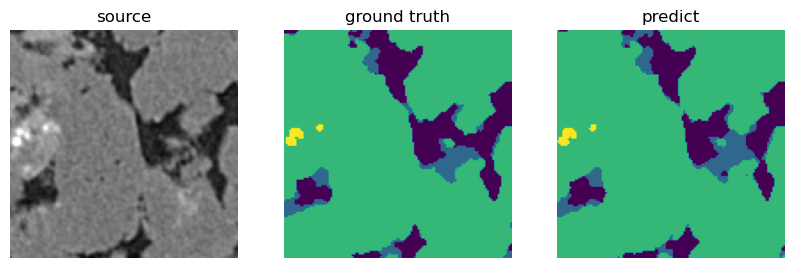

In [ ]:
for i in range(1) :
    idx = randint(0, len(x_test))

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(x_test[idx])
    axs[0].set_title("source")
    axs[0].axis('off')

    axs[1].imshow(y_test[idx])
    axs[1].set_title("ground truth")
    axs[1].axis('off')

    axs[2].imshow(y_pred_argmax[idx])
    axs[2].set_title("predict")
    axs[2].axis('off')
